# WeatherML

## Setup Notebook

### Import Libraries

In [114]:
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

### Set Constants

In [115]:
COLOR_MAPPING = {
    'none': 'red',
    'jacket-short': 'orange',
    'jacket-long': 'green',
    'coat': 'blue'
}

RANDOM_STATE = 17

MONTHS = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']

## Data Processing

In [116]:
df = pd.read_csv('data/weather_data.csv')
print('# Records:', df.shape[0])
print('# Features:', df.shape[1])
df.head()

# Records: 630
# Features: 9


,Date,Time,Temp (°F),Feels Like (°F),Humidity (%),UV,Wind (mph),Gusts (mph),Outer Clothing
0,07/11/2023,13:55,80,80,44,9,4,NaN,none
1,07/12/2023,12:44,83,83,45,9,4,NaN,none
2,07/13/2023,20:15,75,78,79,0,4,NaN,none
3,07/17/2023,17:38,82,83,49,3,5,NaN,none
4,07/22/2023,18:03,75,76,58,2,4,NaN,none


### Remove Label Units

In [117]:
label_map = {
    'Temp (°F)': 'Temp',
    'Feels Like (°F)': 'Feels Like',
    'Humidity (%)': 'Humidity',
    'Wind (mph)': 'Wind',
    'Gusts (mph)': 'Gusts',
}
df.rename(columns=label_map, inplace=True)

### Date Type Cleaning

In [118]:
# convert humidity to decimal percents
df['Humidity'] = df['Humidity'] / 100

# convert dates to datetime
df['Date'] = pd.to_datetime(df['Date'])

### Add Season Data

In [119]:
def get_season(date: datetime) -> str:
    if date.month in [12, 1, 2]:
        return 'Winter'
    elif date.month in [3, 4, 5]:
        return 'Spring'
    elif date.month in [6, 7, 8]:
        return 'Summer'
    elif date.month in [9, 10, 11]:
        return 'Fall'

df['Season'] = [get_season(date_str) for date_str in df['Date']]

### Interpolate Gusts Data

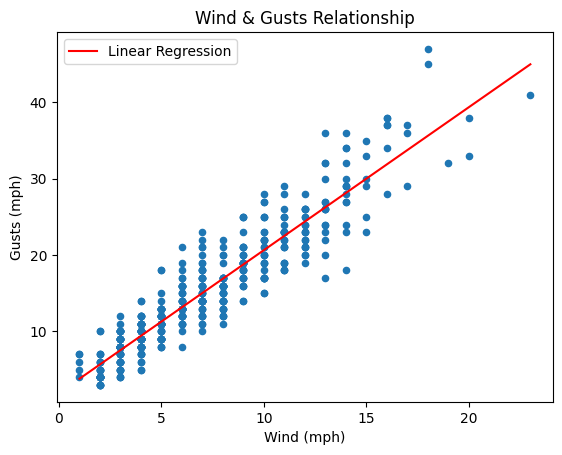

In [120]:
df_gust = df.copy()

# prep data
non_missing = df_gust.dropna(subset=['Gusts'])
missing = df_gust[df_gust['Gusts'].isnull()]

X_train = non_missing[['Wind']].values
y_train = non_missing['Gusts'].values

# train model
model = LinearRegression()
model.fit(X_train, y_train)

# plot data points & regression line
m, b = model.coef_[0], model.intercept_
x_line = np.linspace(df_gust['Wind'].values.min(), df_gust['Wind'].values.max())
y_line = m * x_line + b
df_gust.dropna().plot.scatter('Wind', 'Gusts');
plt.plot(x_line, y_line, color='red', label='Linear Regression')
plt.title('Wind & Gusts Relationship')
plt.xlabel('Wind (mph)')
plt.ylabel('Gusts (mph)')
plt.legend();

In [121]:
X_missing = missing[['Wind']].values
df.loc[df['Gusts'].isnull(), 'Gusts'] = model.predict(X_missing).round()
df.head()

,Date,Time,Temp,Feels Like,Humidity,UV,Wind,Gusts,Outer Clothing,Season
0,2023-07-11,13:55,80,80,0.44,9,4,9.0,none,Summer
1,2023-07-12,12:44,83,83,0.45,9,4,9.0,none,Summer
2,2023-07-13,20:15,75,78,0.79,0,4,9.0,none,Summer
3,2023-07-17,17:38,82,83,0.49,3,5,11.0,none,Summer
4,2023-07-22,18:03,75,76,0.58,2,4,9.0,none,Summer


## Data Analysis & Visualizations

### Target Class Distribution

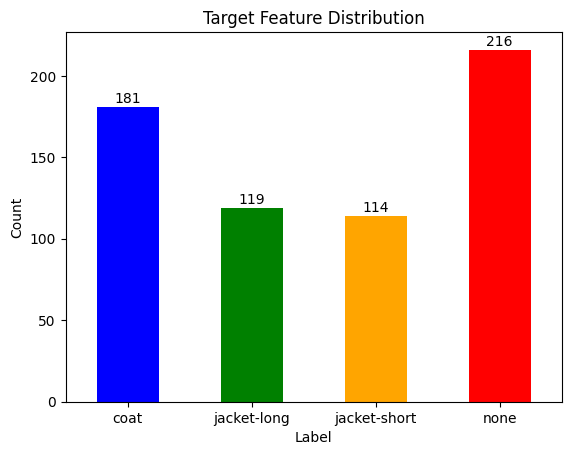

In [122]:
label_distr = df['Outer Clothing'].value_counts().sort_index()
colors = [COLOR_MAPPING[label] for label in label_distr.index]

ax = label_distr.plot(kind='bar', color=colors)
for i, count in enumerate(label_distr):
    ax.text(i, count + 5, f'{label_distr.iloc[i]}', ha='center', va='center')

plt.title('Target Feature Distribution')
plt.xticks(rotation=0)
plt.xlabel('Label')
plt.ylabel('Count');

### Date Distribution

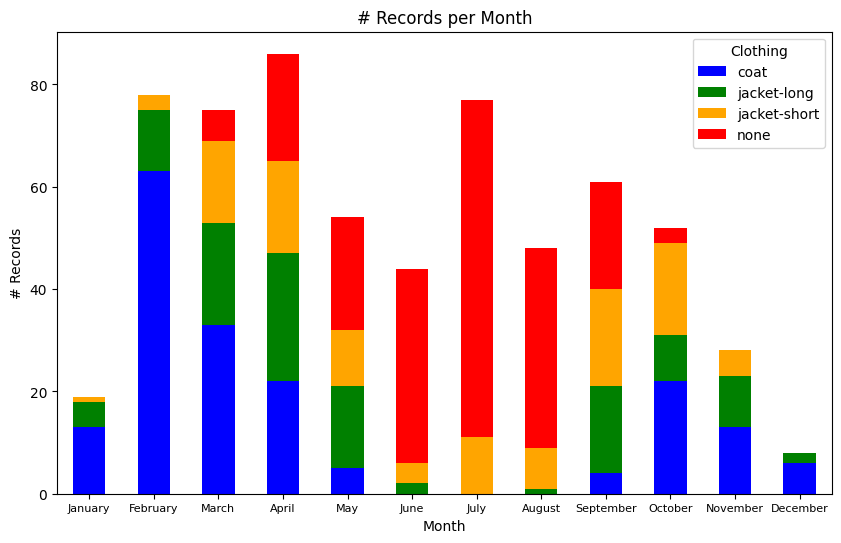

In [123]:
df_date = df[['Date', 'Outer Clothing']].copy()
df_date['Month'] = df_date['Date'].dt.month_name()
month_group = df_date.groupby(['Month', 'Outer Clothing']).size().reset_index(name='Count')
pivot = month_group.pivot(index='Month', columns='Outer Clothing', values='Count')
pivot = pivot.reindex(MONTHS)

ax = pivot.plot(kind='bar', stacked=True, figsize=(10, 6), color=['blue', 'green', 'orange', 'red'])
plt.title('# Records per Month')
plt.xlabel('Month')
plt.ylabel('# Records')
plt.xticks(rotation=0, size=8)
plt.legend(title='Clothing');

## Machine Learning Models